In [1]:
import numpy as np
import collections
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import mean_squared_error as mse
import operator

import math
import keras
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers


def load_animal_data():

    animals_data = np.genfromtxt('data_lab2/animals.dat', delimiter=',')
    animals_data.shape = (32, 84)

    animal_names = np.genfromtxt('data_lab2/animalnames.txt', dtype='str')

    for i in range(len(animal_names)):

        animal_names[i] = animal_names[i].replace("'","")

    return animals_data, animal_names

def load_mp_data():

    mp_votes = np.genfromtxt('data_lab2/votes.dat', delimiter=',')
    mp_votes.shape = (349, 31)

    mp_party = np.genfromtxt('data_lab2/mpparty.dat', comments="%")

    mp_sex = np.genfromtxt('data_lab2/mpsex.dat', comments="%")
    
    mp_district = np.genfromtxt('data_lab2/mpdistrict.dat', comments="%")
   
    return mp_votes, mp_party, mp_sex, mp_district


class SOM():
    def __init__(self, nodes, dims):
        self.nodes = np.random.rand(nodes[0],nodes[1])
        self.num_nodes = nodes[0]
        self.dims = dims
        
        if dims == 2:
            self.height = nodes[0]
        else:
            self.height = self.width = int(np.sqrt(nodes[0]))
    
    def similarity(self, x, nodes):
        min_dist = 99999
        min_idx = 0
        for row in range(self.num_nodes):
            sim = np.linalg.norm(x - nodes[row])
            if (sim < min_dist):
                min_dist = sim
                min_idx = row
        return min_idx, min_dist
    
    def update_weights(self, x, eta, i):
        self.nodes[i] = self.nodes[i] + eta*(x - self.nodes[i])
        
    def update_neighboors(self, x, winner_idx, nbhd_size, eta, circular = False):
       
        if self.dims == 2:
            for i in range(max(0,winner_idx-nbhd_size),min(winner_idx+nbhd_size,self.num_nodes)):
                    self.update_weights(x,eta,i)

            if circular == True:
                print("asfg")
                
        else:
            winner_i = winner_idx // self.height
            winner_j = winner_idx % self.width
            
            for i in range(max(0,winner_i-nbhd_size),min(winner_i+nbhd_size,self.height)):
                for j in range(max(0,winner_j-nbhd_size),min(winner_j+nbhd_size,self.width)):
                    self.update_weights(x,eta,i*self.height+j)
                

    def train(self, X, init_nbhd_size, n_epochs, eta, circular = False):
        
        nbhd_size = init_nbhd_size
        
        for epoch in range(n_epochs):
            for i in range(len(X)):
                min_idx, min_dist = self.similarity(X[i,:],self.nodes)
                self.update_neighboors(X[i,:],min_idx,int(round(nbhd_size)),eta,circular)
            nbhd_size = nbhd_size - init_nbhd_size/n_epochs

    
    def run(self, X, labels):
        results = dict()
        
        if self.dims == 2:
            for i in range(len(X)):
                min_idx, min_dist = self.similarity(X[i,:],self.nodes)
                results[labels[i]] = min_idx
                #print(labels[i],"is represented best by node:",min_idx)
        else:
            for i in range(len(X)):
                min_idx, min_dist = self.similarity(X[i,:],self.nodes)
                if min_idx not in results:
                    results[min_idx] = [labels[i]]
                else:
                    results[min_idx].append(labels[i])
        return results  
    
    


Using TensorFlow backend.


In [2]:
data, names = load_animal_data()
network = SOM([100,84],2)

network.train(data,50,20,eta=0.2)
results = network.run(data,names)
print(sorted(results.items(), key=operator.itemgetter(1)))

[('beetle', 0), ('grasshopper', 0), ('butterfly', 1), ('dragonfly', 1), ('housefly', 4), ('moskito', 4), ('spider', 10), ('duck', 18), ('pelican', 18), ('penguin', 21), ('ostrich', 24), ('frog', 29), ('seaturtle', 32), ('crocodile', 35), ('walrus', 44), ('hyena', 50), ('bear', 52), ('dog', 55), ('lion', 59), ('cat', 62), ('ape', 65), ('skunk', 68), ('bat', 72), ('rabbit', 77), ('rat', 80), ('elephant', 83), ('kangaroo', 86), ('antelop', 89), ('pig', 92), ('camel', 95), ('giraffe', 95), ('horse', 98)]


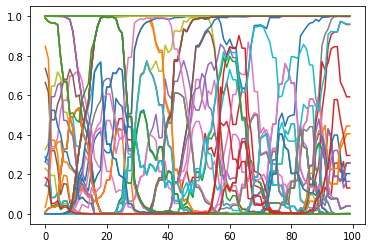

In [3]:
plt.plot(network.nodes)

In [182]:
votes, parties, sex, districts = load_mp_data()

print(votes.shape,parties.shape)

network = SOM([100,31],3)

network.train(votes,5,300,eta=0.2)

(349, 31) (349,)


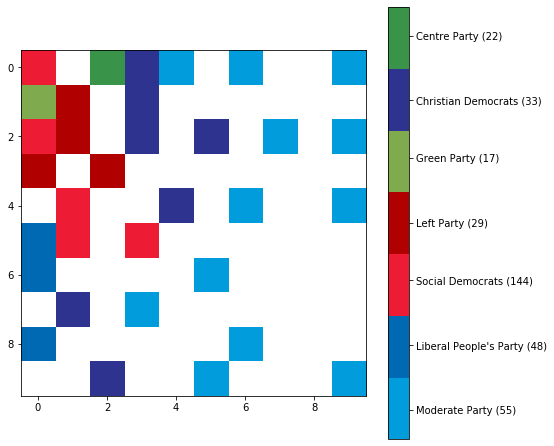

In [183]:
res_by_party = network.run(votes,parties)
# print(collections.Counter(parties))

party_dist = np.zeros([10,10])
for key, value in res_by_party.items():
    party_dist[key//10,key%10] = max(set(value), key=value.count)
np.set_printoptions(threshold=np.inf)

party_dist[party_dist == 0] = float('NaN')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
n = 7
colors = ['#019CDB', '#0069b4', '#ed1b34', '#b00000', '#80AA4E', '#2D338E', '#39944A']

cmap= matplotlib.colors.ListedColormap(colors)
cmap.set_bad(color="white")
im = plt.imshow(party_dist, cmap=cmap)
norm= matplotlib.colors.BoundaryNorm(np.arange(0,n+1)-0.5, n)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
q = plt.colorbar(norm=norm, spacing='proportional')

loc = [1.4, 2.3, 3.2, 4, 4.9, 5.7, 6.6]
q.set_ticks(loc)

q.set_ticklabels(["Moderate Party (55)","Liberal People's Party (48)","Social Democrats (144)", \
                  "Left Party (29)","Green Party (17)","Christian Democrats (33)","Centre Party (22)"])
plt.subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)


(17, 31)
[[ 1. nan nan nan nan nan nan nan nan nan]
 [ 1. nan nan nan nan nan nan nan nan nan]
 [ 1. nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan  1. nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]


Text(0.5, 0.98, '                    Vote distribution of the Green party')

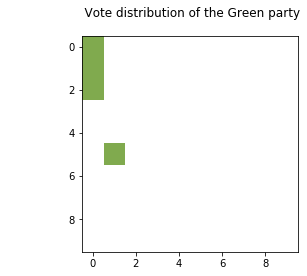

In [184]:
green_votes = np.zeros([np.count_nonzero(parties == 5),31])
print(green_votes.shape)
green_counter = 0
for i in range(len(parties)):
    if(parties[i]==5):
        green_votes[green_counter] = votes[i]
        green_counter += 1

res_greens = network.run(green_votes,parties[parties==5])
green_dist = np.zeros([10,10])
for key, value in res_greens.items():
    green_dist[key//10,key%10] = max(set(value), key=value.count)
np.set_printoptions(threshold=np.inf)

green_dist[green_dist == 0] = float('NaN')
green_dist[green_dist == 5] = 1
print(green_dist)
fig = plt.figure(figsize=(5, 5))
colors = ['#80AA4E']

cmap= matplotlib.colors.ListedColormap(colors)
cmap.set_bad(color="white")
im = plt.imshow(green_dist, cmap=cmap)
plt.subplots_adjust(left=0.3, right=0.9, bottom=0.3, top=0.9)
fig.suptitle("                    Vote distribution of the Green party")

Counter({0.0: 186, 1.0: 163})


<Figure size 432x288 with 0 Axes>

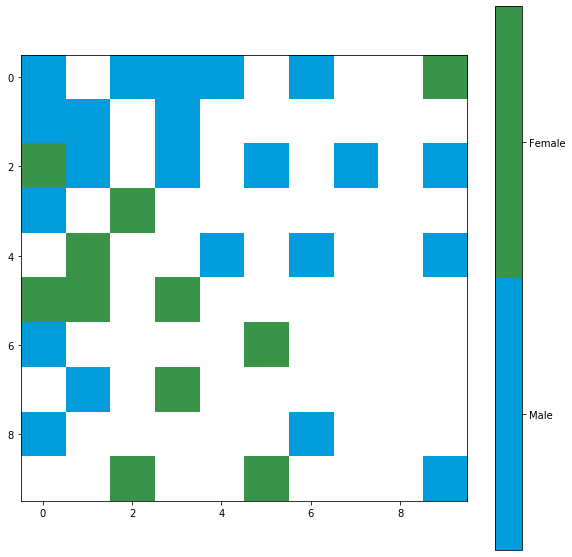

In [187]:
res_by_sex = network.run(votes,sex)
print(collections.Counter(sex))


sex_dist = np.zeros([10,10])
for key, value in res_by_sex.items():
    sex_dist[key//10,key%10] = max(set(value), key=value.count) + 1
sex_dist[sex_dist == 0] = float('NaN')

plt.clf()

fig = plt.figure(figsize=(10, 10))
colors = ['#019CDB', '#39944A']

cmap= matplotlib.colors.ListedColormap(colors)

cmap.set_bad(color="white")
n = 2

norm= matplotlib.colors.BoundaryNorm(np.arange(0,n+1)-0.5, n)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
q = plt.colorbar(sm,ticks=[np.arange(0,n)])
q.set_ticklabels(["Male","Female"])
im = plt.imshow(sex_dist, cmap=cmap)


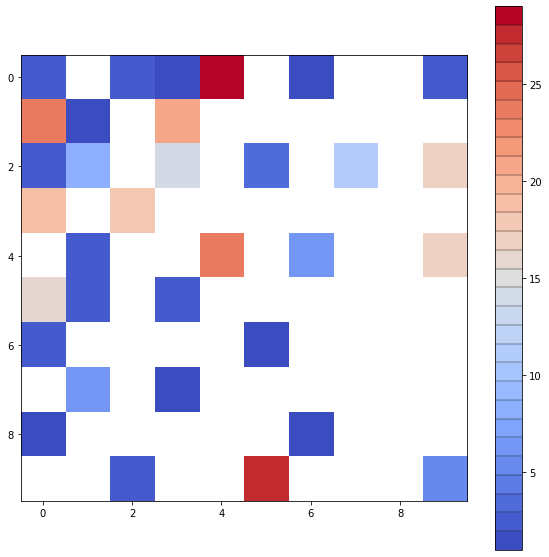

In [186]:
res_by_district = network.run(votes,districts)
# print(collections.Counter(parties))


district_dist = np.zeros([10,10])
for key, value in res_by_district.items():
    district_dist[key//10,key%10] = max(set(value), key=value.count)
district_dist[district_dist == 0] = float('NaN')


cmap = matplotlib.cm.get_cmap('coolwarm', 29)
cmap.set_bad(color="white")

fig = plt.figure(figsize=(10, 10))
im = plt.imshow(district_dist, cmap=cmap)

plt.colorbar(im,drawedges=True)